In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import re
from math import sqrt, log

In [2]:
# Load the predictions and model equations
predictions_df = pd.read_csv("predictions_with_pysr.csv")
equations_df = pd.read_csv("hall_of_fame.csv")

# Preview both to ensure they loaded correctly
display(predictions_df.head(), equations_df.head())

,PLAYER_NAME,PLAYER_ID,GAME_DATE,TEAM_ID,OPP_TEAM_ID,HOME_AWAY,rolling_pts_avg_5G,rolling_pts_median_5G,rolling_3pm_avg_5G,rolling_3pm_median_5G,...,rolling_screen_ast_5g,touches_to_pts_ratio,transition_pts_pct,volume_times_efficiency,usg_min_product,scoring_touch_ratio,volume_efficiency_to_pts,adjusted_shot_creation,PTS,pysr_prediction
0,Jayson Tatum,1628369,2024-11-01,1610612738,1610612766,0,27.666667,31.0,4.000000,4.0,...,0.833333,0.344398,0.096386,27.666667,10.264333,0.269670,11.026196,20.387000,32,26.784348
1,Jayson Tatum,1628369,2024-11-02,1610612738,1610612766,0,26.833333,28.5,3.166667,3.0,...,0.833333,0.329918,0.130435,26.833333,10.548778,0.243655,10.281052,20.505000,29,20.832271
2,Jayson Tatum,1628369,2024-11-04,1610612738,1610612737,0,27.500000,30.5,2.833333,2.0,...,0.666667,0.319149,0.115152,27.500000,10.790722,0.236142,11.259722,19.646833,28,29.760387
3,Jayson Tatum,1628369,2024-11-06,1610612738,1610612744,1,26.000000,28.5,2.833333,2.0,...,0.500000,0.314516,0.179487,26.000000,10.296111,0.228207,10.405571,18.857833,32,28.768374
4,Jayson Tatum,1628369,2024-11-08,1610612738,1610612751,1,31.600000,32.0,4.000000,5.0,...,0.200000,0.377088,0.151899,31.600000,11.289600,0.331000,15.657421,20.192200,33,33.728439


,Complexity,Loss,Equation
0,1,76.785200,adjusted_shot_creation
1,2,73.234070,ceil(adjusted_shot_creation)
2,3,45.900380,delta_fga_vs_rolling * adjusted_shot_creation
3,4,40.072823,ceil(adjusted_shot_creation * delta_fga_vs_rol...
4,5,25.104034,delta_fga_vs_rolling * (adjusted_shot_creation...


In [3]:
# Clean up column names (in case any equations rely on these)
predictions_df.columns = [col.strip() for col in predictions_df.columns]

# Step 1: Define evaluation thresholds
tiers = [10, 15, 20, 25]

# Step 2: Prepare equation application
def extract_variables(eq):
    tokens = re.findall(r'\b[a-zA-Z_][a-zA-Z0-9_]*\b', eq)
    return sorted(set(t for t in tokens if t not in {'sqrt', 'log'}))

def safe_eval(eq, row):
    try:
        variables = {k: row[k] for k in extract_variables(eq)}
        return eval(eq, {"__builtins__": None, "sqrt": sqrt, "log": log}, variables)
    except Exception:
        return np.nan

In [4]:
# Step 3: Evaluate each complexity level
results = []

for _, row in equations_df.iterrows():
    complexity = row["Complexity"]
    equation = row["Equation"].replace("^", "**")
    
    # Apply prediction
    preds = predictions_df.apply(lambda r: safe_eval(equation, r), axis=1)
    #floored_preds = np.floor(preds / 5) * 5
    
    win_rates = {}
    for tier in tiers:
        actual_hits = predictions_df["PTS"] >= tier
        pred_hits = preds >= tier
        win_rate = (actual_hits & pred_hits).sum() / actual_hits.sum() if actual_hits.sum() > 0 else np.nan
        win_rates[f"hit_{tier}"] = win_rate

    results.append({
        "complexity": complexity,
        **win_rates
    })

In [5]:
# Convert to DataFrame
eval_df = pd.DataFrame(results).sort_values("complexity")

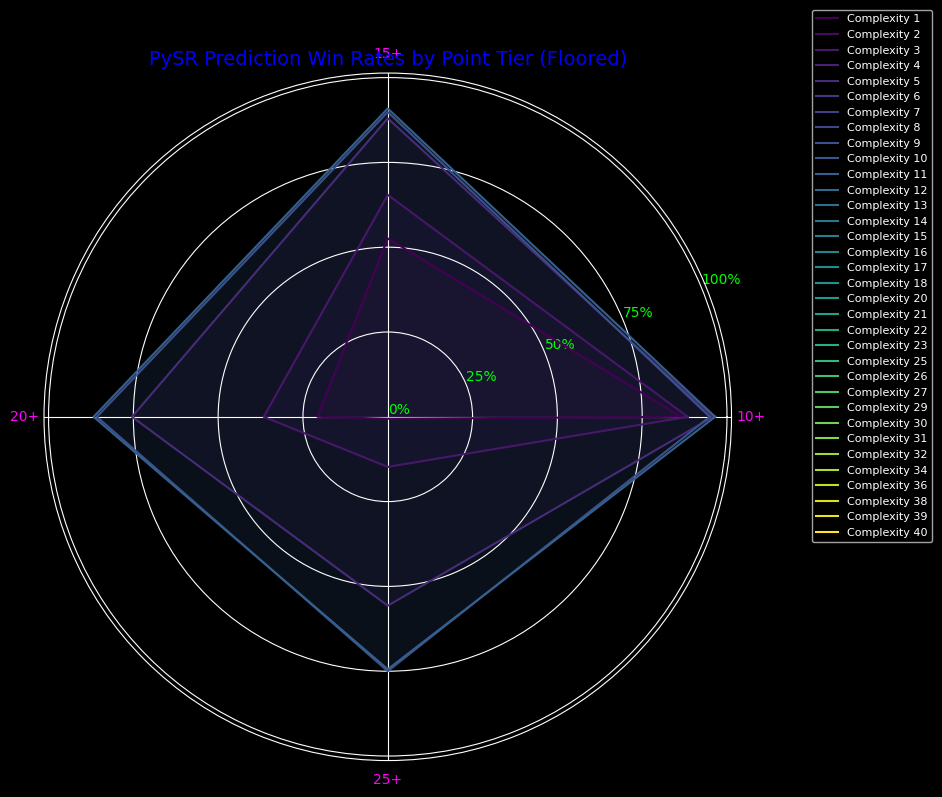

In [6]:
# Plot radar chart
categories = [f"hit_{t}" for t in tiers]
angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
angles += angles[:1]

plt.style.use("dark_background")

plt.figure(figsize=(10, 8), facecolor='black', edgecolor='green')
cmap = plt.get_cmap("viridis", len(eval_df))

for i, (_, row) in enumerate(eval_df.iterrows()):
    values = [row[cat] if not pd.isna(row[cat]) else 0 for cat in categories]
    values += values[:1]  # loop around
    ax = plt.subplot(111, polar=True)
    ax.plot(angles, values, label=f"Complexity {int(row['complexity'])}", color=cmap(i))
    ax.fill(angles, values, alpha=0.1, color=cmap(i))

ax.set_xticks(angles[:-1])
ax.set_xticklabels([f"{t}+" for t in tiers], color='magenta')
ax.set_yticks(np.linspace(0, 1, 5))
ax.set_yticklabels([f"{int(x * 100)}%" for x in np.linspace(0, 1, 5,)], color='lime')
#ax.tick_params(colors='magenta')
plt.title("PySR Prediction Win Rates by Point Tier (Floored)", fontsize=14, color='blue')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=8)
plt.tight_layout()
plt.show()